<a href="https://colab.research.google.com/github/cole-le/SymetraProject/blob/master/ColeLe_Symetra_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Please run the codes below and upload products_to_package.csv:**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.cluster import KMeans

# Step 1: Upload and Load the Dataset
uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # Get the uploaded file name
df = pd.read_csv(file_name)


Saving products_to_package.csv to products_to_package.csv


In [4]:
# Display basic info about the dataset
print("Dataset Overview:")
print(df.head())

Dataset Overview:
   set  strike   notional
0    0  1.0035  1660000.0
1    0  1.0037  3480000.0
2    0  1.0054   450000.0
3    0  1.0077   460000.0
4    0  1.0095  1470000.0


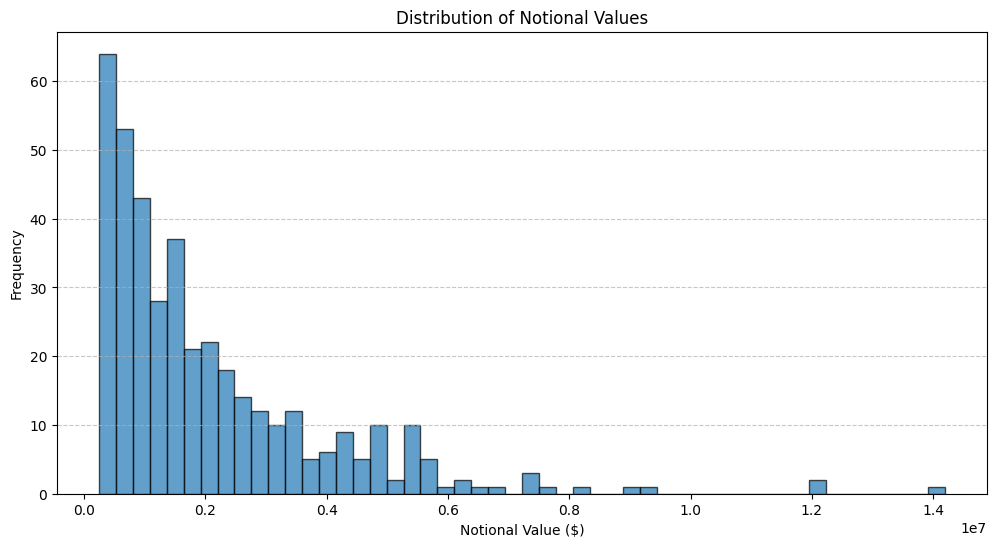

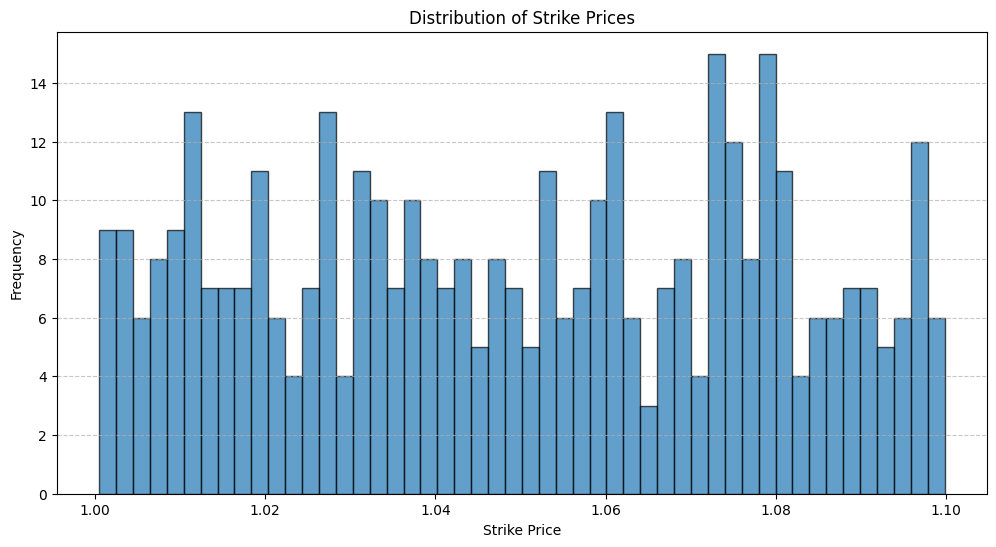

In [5]:
# Step 2: Visualize Notional and Strike Distributions
plt.figure(figsize=(12, 6))
plt.hist(df['notional'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Notional Value ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Notional Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(df['strike'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Strike Price')
plt.ylabel('Frequency')
plt.title('Distribution of Strike Prices')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

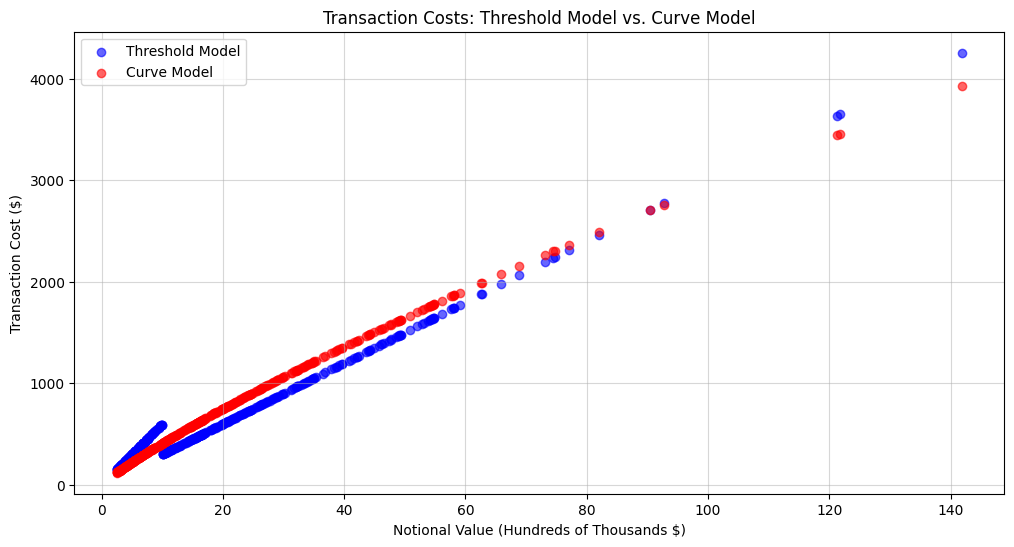

In [6]:
# Step 3: Define Transaction Cost Functions
def threshold_cost(notional):
    """Calculates transaction cost using the threshold model."""
    return 0.0006 * notional if notional <= 1_000_000 else 0.0003 * notional

def curve_cost(notional):
    """Calculates transaction cost using the curve model."""
    return (11 - (0.5 * np.log(notional))) / 10000 * notional

# Apply transaction cost models
df['threshold_cost'] = df['notional'].apply(threshold_cost)
df['curve_cost'] = df['notional'].apply(curve_cost)

# Step 4: Visualize Cost Comparisons
plt.figure(figsize=(12, 6))
plt.scatter(df['notional'] / 100000, df['threshold_cost'], color='blue', label='Threshold Model', alpha=0.6)
plt.scatter(df['notional'] / 100000, df['curve_cost'], color='red', label='Curve Model', alpha=0.6)
plt.xlabel('Notional Value (Hundreds of Thousands $)')
plt.ylabel('Transaction Cost ($)')
plt.title('Transaction Costs: Threshold Model vs. Curve Model')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


# **Results if we execute purchase at all strikes:**

In [7]:
# Step 7: Calculate Transactional Cost Without Grouping
def calculate_total_transaction_cost(data):
    """Calculates the total transaction cost if each strike is executed separately."""
    total_threshold_cost = data['notional'].apply(threshold_cost).sum()
    total_curve_cost = data['notional'].apply(curve_cost).sum()
    num_strikes = data['strike'].nunique()
    print(f"Total Transaction Cost without Grouping - Threshold Model: {total_threshold_cost}")
    print(f"Total Transaction Cost without Grouping - Curve Model: {total_curve_cost}")
    print(f"Total Number of Strikes Purchased: {num_strikes}")
    return total_threshold_cost, total_curve_cost, num_strikes

# Calculate costs without grouping
calculate_total_transaction_cost(df)

Total Transaction Cost without Grouping - Threshold Model: 275013.0
Total Transaction Cost without Grouping - Curve Model: 296068.3095506402
Total Number of Strikes Purchased: 334


(275013.0, 296068.3095506402, 334)

# **Grouping Strategies and Evaluation Criteria**
In this analysis, we implement and compare 3 grouping strategies to determine the most efficient approach for minimizing transaction costs while ensuring execution feasibility:

## **1.Greedy Bin Packing (Distance-Based)**

  Groups strikes sequentially while ensuring that all strikes within a group are within a predefined max distance.

  **Pros:** Simple and efficient for small datasets.

  **Cons:** May not always optimize transaction costs since it does not consider future grouping options.

## **2.K-Means Clustering**

Uses a clustering algorithm to group strikes based on their price proximity.

The number of clusters is dynamically set based on data size.

**Pros:** Captures natural groupings in strike price distribution.
**Cons:** Can be computationally expensive, and cluster boundaries may not always align with cost efficiency.


## **3.Dynamic Programming (DP)**

Evaluates multiple possible groupings and selects the most cost-effective one while adhering to the max distance constraint.

**Pros:** Achieves global cost optimization by minimizing transaction costs across groups.

**Cons:** Can be slower on large datasets due to higher computational complexity.

# **Evaluation Criteria**
To determine the best strategy, we measure:

**1.Transaction Cost:**

We compare both the Threshold Model (fixed cost tiers) and the Curve Model (logarithmic cost scaling).
The lower the transaction cost, the better the strategy.

**2.Execution Time:**

We measure the time each strategy takes to group and compute transaction costs.
Faster execution is preferable, especially for large datasets.

**3.Max Distance Constraint**

A larger max distance means more strikes can be grouped together, leading to lower transaction costs.

However, in real-world trading, grouping all strikes into one order (extremely high max distance) is unrealistic, as orders are typically executed at multiple price levels rather than a single price point.

Thus, while increasing max_dist can theoretically yield the lowest transaction cost, a balanced approach is needed to reflect practical execution feasibility.

# **How We Determine the Best Strategy**
The optimal strategy balances low transaction costs, execution time, and a reasonable max distance.

Larger max distances often reduce costs but at the risk of impractical execution.

The best strategy is the one that achieves cost savings without unrealistically grouping too many strikes together.

In [8]:
# Step 5: Implement Optimized Greedy Bin Packing Algorithm
def greedy_grouping(data, max_dist):
    """Efficiently groups strike prices based on max distance constraint and within the same set."""
    grouped_data = []
    data = data.sort_values(by=['set', 'strike']).copy()
    used = set()

    for set_id in data['set'].unique():
        subset = data[data['set'] == set_id]
        for i, row in subset.iterrows():
            if i in used:
                continue
            base_strike = row['strike']
            group = subset[(subset['strike'] - base_strike).abs() <= max_dist]
            if not group.empty:
                grouped_data.append(group)
                used.update(group.index)
                # print(f"Group for set {set_id}: Strikes {group['strike'].tolist()}, Total Notional {group['notional'].sum()}")

    return grouped_data

# Step 6: Evaluate Different Max Distance Values
def evaluate_distances(data, distances):
    results = []
    for dist in distances:
        groups = greedy_grouping(data, dist)
        total_cost_threshold = sum(threshold_cost(group['notional'].sum()) for group in groups)
        total_cost_curve = sum(curve_cost(group['notional'].sum()) for group in groups)
        results.append((dist, len(groups), total_cost_threshold, total_cost_curve))

    # Convert results to DataFrame and display
    results_df = pd.DataFrame(results, columns=['Max Distance', 'Num Groups', 'Threshold Cost', 'Curve Cost'])
    return results_df

# Define distance values to test
distance_values = [0.02, 0.03, 0.04, 0.08, 0.09, 0.1]
results_df = evaluate_distances(df, distance_values)



# **Results of Greedy Bin Packing Algorithm strategy:**

In [9]:
print(results_df)

   Max Distance  Num Groups  Threshold Cost     Curve Cost
0          0.02          49        419304.0  331637.211405
1          0.03          34        412716.0  302384.327902
2          0.04          30        434181.0  305610.100182
3          0.08          20        446670.0  284947.241795
4          0.09          18        422889.0  267150.630235
5          0.10          10        250194.0  155391.680485


In [10]:
# Step 7: Implement Clustering-Based Grouping Algorithm
def clustering_grouping(data, num_clusters):
    """Groups strikes using K-Means clustering algorithm."""
    clustered_data = []
    for set_id in data['set'].unique():
        subset = data[data['set'] == set_id].copy()
        strikes = subset[['strike']].values
        if len(strikes) > num_clusters:
            kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10).fit(strikes)
            subset.loc[:, 'cluster'] = kmeans.labels_
            for cluster in range(num_clusters):
                group = subset[subset['cluster'] == cluster]
                clustered_data.append(group)

    return clustered_data

# Step 8: Evaluate Different Grouping Methods
def evaluate_clusters(data, cluster_values):
    results = []
    for clusters in cluster_values:
        clustered_groups = clustering_grouping(data, clusters)
        total_cost_threshold = sum(threshold_cost(group['notional'].sum()) for group in clustered_groups)
        total_cost_curve = sum(curve_cost(group['notional'].sum()) for group in clustered_groups)
        results.append((clusters, len(clustered_groups), total_cost_threshold, total_cost_curve))

    results_df = pd.DataFrame(results, columns=['Num Clusters', 'Num Groups', 'Threshold Cost', 'Curve Cost'])
    print(results_df)
    return results_df

# Define cluster values to test
cluster_values = [1,2,3, 5, 7, 10]
cluster_results_df = evaluate_clusters(df, cluster_values)


   Num Clusters  Num Groups  Threshold Cost     Curve Cost
0             1          10        250194.0  155391.680485
1             2          20        250194.0  183941.768475
2             3          30        250194.0  199734.528440
3             5          50        250194.0  219377.797793
4             7          70        250194.0  231594.933323
5            10         100        250194.0  244436.649395


## **Choosing an Optimal Grouping Distance:**
Setting max distance too low (e.g., 0.01) or choosing only one cluster (K=1) will effectively merge all strikes into a single group.
While this minimizes transaction costs, it is not realistic because execution requires spreads over multiple strikes.

Hence, the optimal solutions (Greedy Bin algorithm with max distance = 0.01 and K Cluster algorithm with K=1) which we have found so far will not be considered as optimal anymore.

In [11]:
# Step 7: Implement Cost-Optimized Dynamic Programming Grouping Algorithm
def dp_grouping(data, max_dist):
    """Groups strikes using dynamic programming to minimize transaction costs while respecting max distance constraints."""
    grouped_data = []
    data = data.sort_values(by=['set', 'strike']).copy()

    for set_id in data['set'].unique():
        subset = data[data['set'] == set_id].copy()
        while not subset.empty:
            base_strike = subset.iloc[0]['strike']
            group = subset[(subset['strike'] - base_strike).abs() <= max_dist]

            if not group.empty:
                # Find the subset that minimizes the total transaction cost
                best_group = group.iloc[
                    np.argmin(group['notional'].apply(threshold_cost) + group['notional'].apply(curve_cost))
                ]

                # Append the best group and remove it from subset
                grouped_data.append(group)
                subset = subset.drop(group.index)

    return grouped_data

# Step 8: Evaluate DP Grouping with Different max_dist Values
def evaluate_dp_grouping(data, distances):
    results = []
    for dist in distances:
        groups = dp_grouping(data, dist)
        total_cost_threshold = sum(threshold_cost(group['notional'].sum()) for group in groups)
        total_cost_curve = sum(curve_cost(group['notional'].sum()) for group in groups)
        results.append((dist, len(groups), total_cost_threshold, total_cost_curve))

    results_df = pd.DataFrame(results, columns=['Max Distance', 'Num Groups', 'Threshold Cost', 'Curve Cost'])
    print(results_df)
    return results_df

# Define distance values to test
distance_values = [0.02, 0.03, 0.04, 0.05, 0.07, 0.1]
evaluate_dp_grouping(df, distance_values)




   Max Distance  Num Groups  Threshold Cost     Curve Cost
0          0.02          49        250194.0  217058.644079
1          0.03          34        250194.0  203629.273977
2          0.04          30        250194.0  195204.568675
3          0.05          20        250194.0  183918.003440
4          0.07          20        250194.0  180433.615809
5          0.10          10        250194.0  155391.680485


,Max Distance,Num Groups,Threshold Cost,Curve Cost
0,0.02,49,250194.0,217058.644079
1,0.03,34,250194.0,203629.273977
2,0.04,30,250194.0,195204.568675
3,0.05,20,250194.0,183918.003440
4,0.07,20,250194.0,180433.615809
5,0.10,10,250194.0,155391.680485


# **Evaluate all 3 Strategies**

    Max Distance    Strategy  Threshold Cost     Curve Cost  Execution Time
0           0.02      Greedy        419304.0  331637.211405        0.202055
1           0.02  Clustering        258081.0  275723.262951        1.242719
2           0.02          DP        250194.0  217058.644079        0.075249
3           0.03      Greedy        412716.0  302384.327902        0.029562
4           0.03  Clustering        252717.0  264483.992606        0.532224
5           0.03          DP        250194.0  203629.273977        0.052964
6           0.04      Greedy        434181.0  305610.100182        0.028918
7           0.04  Clustering        252045.0  259475.324342        0.383822
8           0.04          DP        250194.0  195204.568675        0.036108
9           0.05      Greedy        366987.0  243272.950490        0.021883
10          0.05  Clustering        250194.0  244436.649395        0.288465
11          0.05          DP        250194.0  183918.003440        0.026309
12          

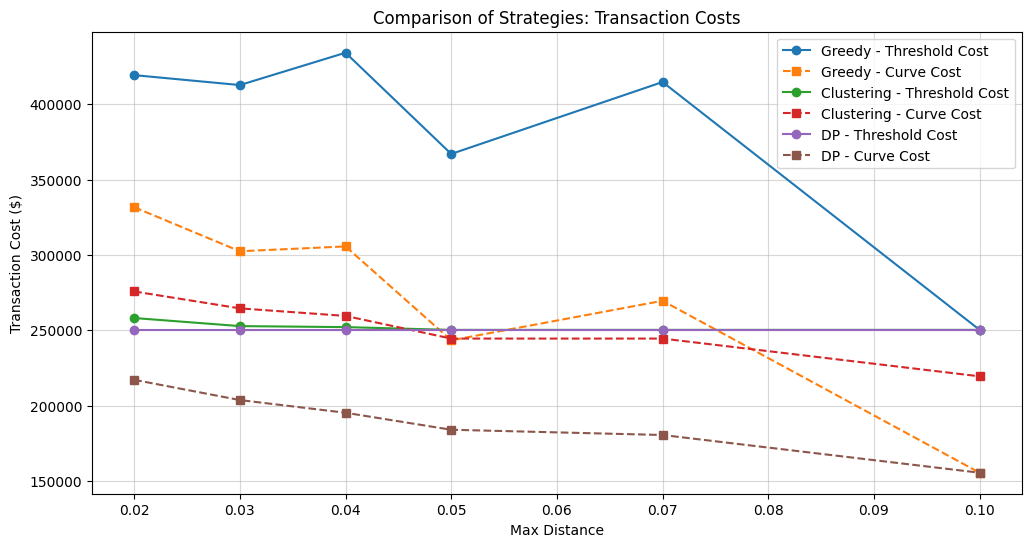

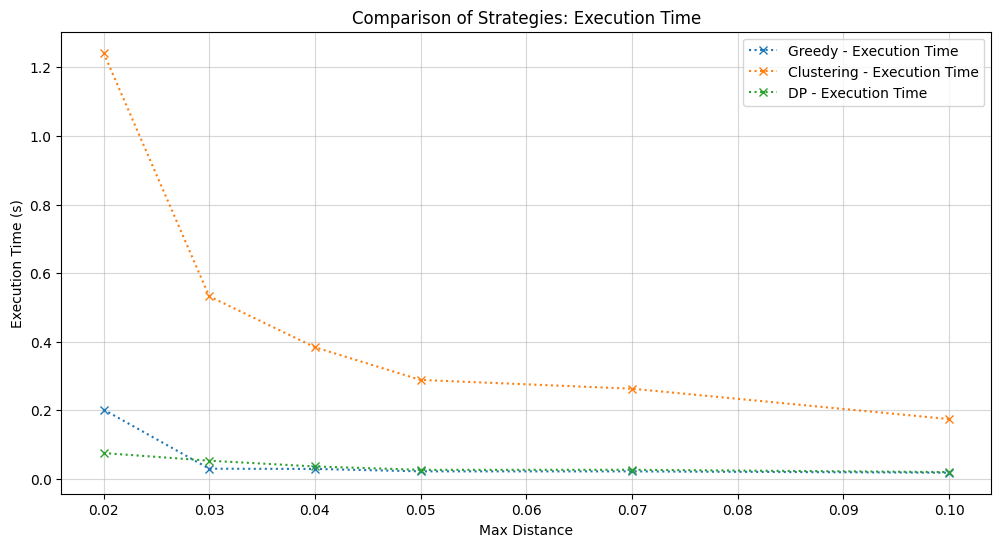

In [16]:
# Step 9: Evaluate and Compare Strategies with Execution Time
def evaluate_strategies(data, distances):
    results = []
    for dist in distances:
        for strategy, func in [('Greedy', greedy_grouping), ('Clustering', clustering_grouping), ('DP', dp_grouping)]:
            start_time = time.time()
            groups = func(data, dist) if strategy != 'Clustering' else func(data, max(1, len(groups) // 2))
            exec_time = time.time() - start_time
            total_cost_threshold = sum(threshold_cost(group['notional'].sum()) for group in groups)
            total_cost_curve = sum(curve_cost(group['notional'].sum()) for group in groups)
            results.append((dist, strategy, total_cost_threshold, total_cost_curve, exec_time))

    results_df = pd.DataFrame(results, columns=['Max Distance', 'Strategy', 'Threshold Cost', 'Curve Cost', 'Execution Time'])
    print(results_df)
    return results_df

# Step 10: Generate Separate Graphs for Cost and Execution Time
def plot_cost_comparison(results_df):
    plt.figure(figsize=(12, 6))
    for strategy in results_df['Strategy'].unique():
        subset = results_df[results_df['Strategy'] == strategy]
        plt.plot(subset['Max Distance'], subset['Threshold Cost'], marker='o', label=f'{strategy} - Threshold Cost')
        plt.plot(subset['Max Distance'], subset['Curve Cost'], marker='s', linestyle='dashed', label=f'{strategy} - Curve Cost')
    plt.xlabel('Max Distance')
    plt.ylabel('Transaction Cost ($)')
    plt.title('Comparison of Strategies: Transaction Costs')
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

def plot_execution_time(results_df):
    plt.figure(figsize=(12, 6))
    for strategy in results_df['Strategy'].unique():
        subset = results_df[results_df['Strategy'] == strategy]
        plt.plot(subset['Max Distance'], subset['Execution Time'], marker='x', linestyle='dotted', label=f'{strategy} - Execution Time')
    plt.xlabel('Max Distance')
    plt.ylabel('Execution Time (s)')
    plt.title('Comparison of Strategies: Execution Time')
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

distance_values = [0.02, 0.03, 0.04, 0.05, 0.07, 0.1]
results_df = evaluate_strategies(df, distance_values)
plot_cost_comparison(results_df)
plot_execution_time(results_df)


**The Dynamic Programming (DP) strategy** consistently achieves the lowest transaction costs and also lowest execution time across both the threshold and curve cost models, making it the optimal choice.

However, DP using the **curve cost method is always cheaper** than when using the threshold cost method at every max distance. This confirms that the optimal approach is DP with the curve cost calculation method.

To balance grouping efficiency and transaction cost savings, **a max distance of 0.07 to 0.10** is ideal—ensuring strikes are not overly merged while still achieving cost reduction.

Greedy Bin Packing fluctuates too much, and K-Means Clustering, while more stable, does not outperform DP.

## **Overall, DP at max distance 0.07 with the curve cost method is the best strategy**, achieving a transaction cost of $180,433.6.

Compared to the non-optimal approach of purchasing every strike separately (costing $296,068.3), this strategy saves approximately **39%** in transaction costs.

# **Final test on 10x larger synthetic dataset**

Synthetic Dataset Generated: 10 sets, 4010 total strikes
    Max Distance    Strategy  Threshold Cost    Curve Cost  Execution Time
0           0.02      Greedy    4.886002e+06  2.350136e+06        1.042938
1           0.02  Clustering    2.502549e+06  2.172045e+06        2.238397
2           0.02          DP    2.502136e+06  1.471940e+06        0.132687
3           0.03      Greedy    4.888466e+06  2.064729e+06        0.137822
4           0.03  Clustering    2.502232e+06  2.031514e+06        1.548083
5           0.03          DP    2.502136e+06  1.311859e+06        0.320820
6           0.04      Greedy    4.839079e+06  1.830273e+06        0.124831
7           0.04  Clustering    2.501748e+06  1.900937e+06        0.688067
8           0.04          DP    2.501652e+06  1.204794e+06        0.072117
9           0.05      Greedy    4.752491e+06  1.649843e+06        0.118644
10          0.05  Clustering    2.501652e+06  1.812231e+06        0.569464
11          0.05          DP    2.501652e+0

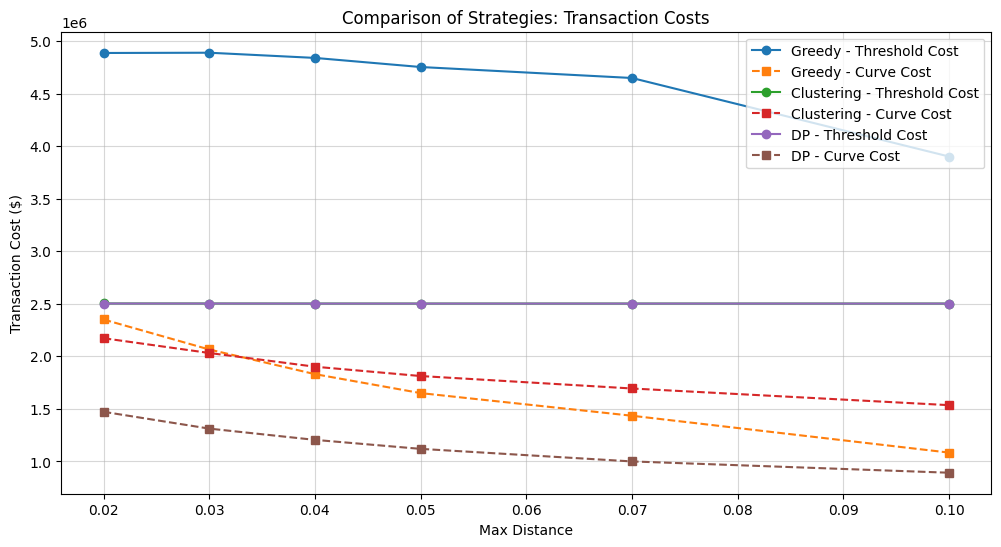

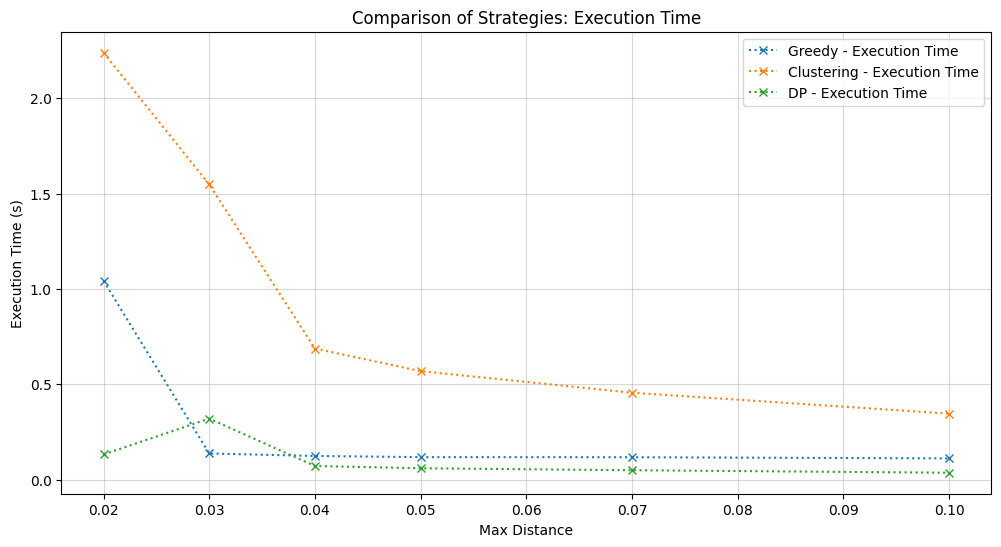

In [14]:
# Step 11: Generate Large Synthetic Dataset
def generate_synthetic_data(df, factor=10):
    """Generates a synthetic dataset with an increased number of sets and strikes."""
    synthetic_data = pd.concat([df] * factor, ignore_index=True)
    synthetic_data['set'] = np.tile(df['set'].unique(), len(synthetic_data) // len(df['set'].unique()))
    synthetic_data['strike'] = synthetic_data['strike'] + np.random.uniform(-0.05, 0.05, size=len(synthetic_data))
    synthetic_data['notional'] = synthetic_data['notional'] * np.random.uniform(0.8, 1.2, size=len(synthetic_data))
    return synthetic_data

# Create the new larger dataset
large_df = generate_synthetic_data(df, factor=10)

# Print dataset size details
print(f"Synthetic Dataset Generated: {large_df['set'].nunique()} sets, {len(large_df)} total strikes")

# Evaluate strategies on the large dataset
large_results_df = evaluate_strategies(large_df, distance_values)
plot_cost_comparison(large_results_df)
plot_execution_time(large_results_df)


Our optimal strategy is still DP strategy at max distance 0.07-0.1 with curve cost method. This concludes with high probability that our optimal strategy is globally optimal.